In [1]:
!pip install lofo-importance

In [2]:
import os
import pandas as pd 
import numpy as np

import plotly.graph_objects as go

import joblib

import optuna
from lofo import LOFOImportance, Dataset, plot_importance

import shap

import seaborn as sns
import matplotlib.pyplot as plt
from optuna.samplers import TPESampler

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings('ignore')


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


# Utils

In [3]:
def one_hot_encoder(df, nan_as_category = False):
    all_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df,
                        columns= categorical_columns,
                        dummy_na= nan_as_category
                       )
    return df

In [4]:
def merge_dfs(df_main, df_merge):
    df_main = df_main.merge(right=df_merge.reset_index(), how='left', on='SK_ID_CURR')
    return df_main

In [5]:
def visualize_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    
    trace = go.Bar(x=missing_values.index,
                   y=missing_values.values,
                   marker=dict(color='orange'))

    layout = go.Layout(title='Missing Values by Feature',
                       xaxis=dict(title='Features'),
                       yaxis=dict(title='Number of Missing Values'))

    fig = go.Figure(data=[trace], layout=layout)

    fig.show()

In [6]:
def visualize_new_features(new_features_list):
    plt.figure(figsize = (8, 6))
    
    for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
        
        plt.subplot(4, 1, i + 1)

        sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
        sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
        plt.title('Distribution of %s by Target Value' % feature)
        plt.xlabel('%s' % feature); plt.ylabel('Density');
    
    plt.tight_layout(h_pad = 2.5)

# Datasets

In [7]:
app_train = pd.read_csv("../input/home-credit-default-risk/application_train.csv")
app_test = pd.read_csv("../input/home-credit-default-risk/application_test.csv")
subm = pd.read_csv("../input/home-credit-default-risk/sample_submission.csv")

In [8]:
labels = app_train['TARGET']

In [9]:
print(app_train.shape, app_test.shape)

(307511, 122) (48744, 121)


In [10]:
app_train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307510,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0


In [11]:
app_test.tail()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
48743,456250,Cash loans,F,Y,N,0,135000.0,312768.0,24709.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [12]:
pos_cash = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')
credit_card = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')
previous_app = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
install_payments = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv')

In [13]:
app_train = one_hot_encoder(app_train) 
app_test = one_hot_encoder(app_test) 
pos_cash = one_hot_encoder(pos_cash) 
credit_card = one_hot_encoder(credit_card)
bureau = one_hot_encoder(bureau)
bureau_balance = one_hot_encoder(bureau_balance)
previous_app = one_hot_encoder(previous_app)
install_payments = one_hot_encoder(install_payments)

In [14]:
prev_apps_count = previous_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_app['SK_ID_PREV'] = previous_app['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

prev_apps_avg = previous_app.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['P_' + col for col in prev_apps_avg.columns]

app_train = merge_dfs(app_train, prev_apps_avg)
app_test = merge_dfs(app_test, prev_apps_avg)

In [15]:
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['BUREAU_COUNT'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['B_' + col for col in bureau_avg.columns]

app_train = merge_dfs(app_train, bureau_avg)
app_test = merge_dfs(app_test, bureau_avg)

In [16]:
install_count = install_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
install_payments['SK_ID_PREV'] = install_payments['SK_ID_CURR'].map(install_count['SK_ID_PREV'])

install_avg = install_payments.groupby('SK_ID_CURR').mean()
install_avg.columns = ['I_' + col for col in install_avg.columns]

app_train = merge_dfs(app_train, install_avg)
app_test = merge_dfs(app_test, install_avg)

In [17]:
prev_credit_count = credit_card[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card['SK_ID_PREV'] = credit_card['SK_ID_CURR'].map(prev_credit_count['SK_ID_PREV'])

avg_credit_bal = credit_card.groupby('SK_ID_CURR').mean()
avg_credit_bal.columns = ['CC_B_' + col for col in avg_credit_bal.columns]

app_train = merge_dfs(app_train, avg_credit_bal)
app_test = merge_dfs(app_test, avg_credit_bal)

In [18]:
app_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_B_CNT_INSTALMENT_MATURE_CUM,CC_B_SK_DPD,CC_B_SK_DPD_DEF,CC_B_NAME_CONTRACT_STATUS_Active,CC_B_NAME_CONTRACT_STATUS_Approved,CC_B_NAME_CONTRACT_STATUS_Completed,CC_B_NAME_CONTRACT_STATUS_Demand,CC_B_NAME_CONTRACT_STATUS_Refused,CC_B_NAME_CONTRACT_STATUS_Sent proposal,CC_B_NAME_CONTRACT_STATUS_Signed
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1.Preprocess & EDA
**Future works:**
1. 

I saw these Domain Knowledge Features and integrated my dataset.
* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age



In [19]:
correlations = app_train.corr()['TARGET'].sort_values(ascending=False)
top_correlations = correlations.head(15)

In [20]:
top_correlations

TARGET                            1.000000
CC_B_CNT_DRAWINGS_ATM_CURRENT     0.107692
B_DAYS_CREDIT                     0.089729
CC_B_AMT_BALANCE                  0.087177
CC_B_AMT_TOTAL_RECEIVABLE         0.086490
CC_B_AMT_RECIVABLE                0.086478
CC_B_AMT_RECEIVABLE_PRINCIPAL     0.086062
CC_B_CNT_DRAWINGS_CURRENT         0.082520
DAYS_BIRTH                        0.078239
P_NAME_CONTRACT_STATUS_Refused    0.077671
B_CREDIT_ACTIVE_Active            0.077356
CC_B_AMT_INST_MIN_REGULARITY      0.073724
B_DAYS_CREDIT_UPDATE              0.068927
CC_B_MONTHS_BALANCE               0.062081
REGION_RATING_CLIENT_W_CITY       0.060893
Name: TARGET, dtype: float64

In [21]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

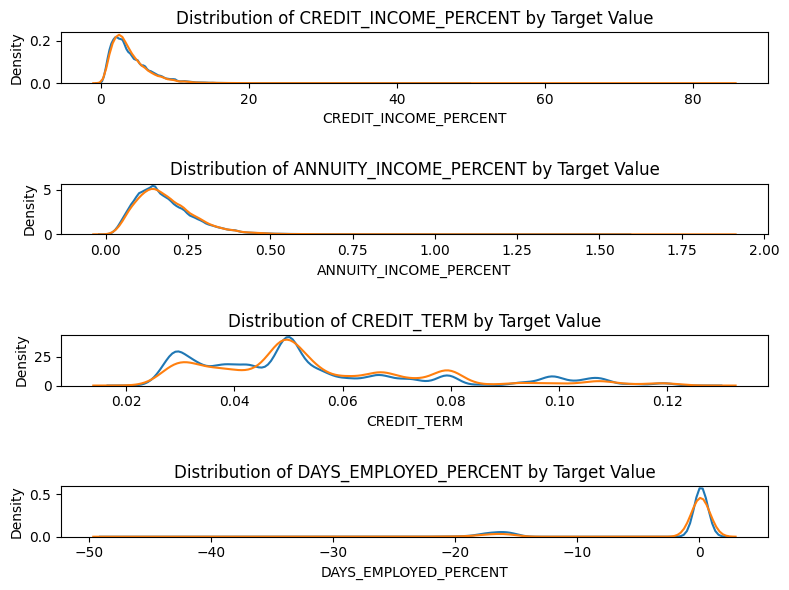

In [22]:
visualize_new_features(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT'])

### I use app_train_domain because new features looks good correlated by target

In [23]:
visualize_missing_values(app_train_domain)


In [24]:
app_train_domain.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)
app_test_domain.drop(['SK_ID_CURR'], axis=1, inplace=True)

#### Future work: There are 4 unique columns in test set but not in train such as NAME_FAMILY_STATUS_Unknown. 

In [25]:
train = app_train_domain.copy()
test = app_test_domain.copy()

train = train.fillna(train.mode().iloc[0])
test = test.fillna(test.mode().iloc[0])


In [26]:
print(train.columns[train.isnull().any()])
print(test.columns[test.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


# 2. Stradified KFold 

In [27]:
def cross_validate_model(model, X, y, cv):
    auc_scores = []
        
    for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
        
        if isinstance(model, CatBoostClassifier):
            model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv), verbose=False)
            y_pred_prob = model.predict_proba(X_val_cv)[:, 1]
        else:
            model.fit(X_train_cv, y_train_cv)
            y_pred_prob = model.predict(X_val_cv)
        
        auc_score = roc_auc_score(y_val_cv, y_pred_prob)
        auc_scores.append(auc_score)
    
    return np.mean(auc_scores)

In [28]:
stk_fold = StratifiedKFold(n_splits = 5, shuffle = False)

# 3. Create Baseline Catboost and Ridge Models

In [29]:
cb_model = CatBoostClassifier(iterations=100, 
                                  learning_rate=0.1,
                                  eval_metric='AUC',
                                  verbose=False,
                                  random_seed=43)

ridge_model = RidgeClassifier(alpha=1.0)

In [30]:
cb_model_score = cross_validate_model(cb_model, train, labels, stk_fold)
print(f"The baseline metric for CatBoost is {cb_model_score}")

The baseline metric for CatBoost is 0.7695704410569817


In [31]:
ridge_score = cross_validate_model(ridge_model, train, labels, stk_fold)
print(f"The baseline metric for Ridge is {ridge_score}")

The baseline metric for Ridge is 0.5002003258800902


# 4. LOFO Importance 

#### Pros
* Give insight about the most important features

#### Cons
* Time-consuming especially when I tried catboost model

### Future Work: Feature importance plot is too complex maybe I drop some features.

  0%|          | 0/483 [00:00<?, ?it/s]

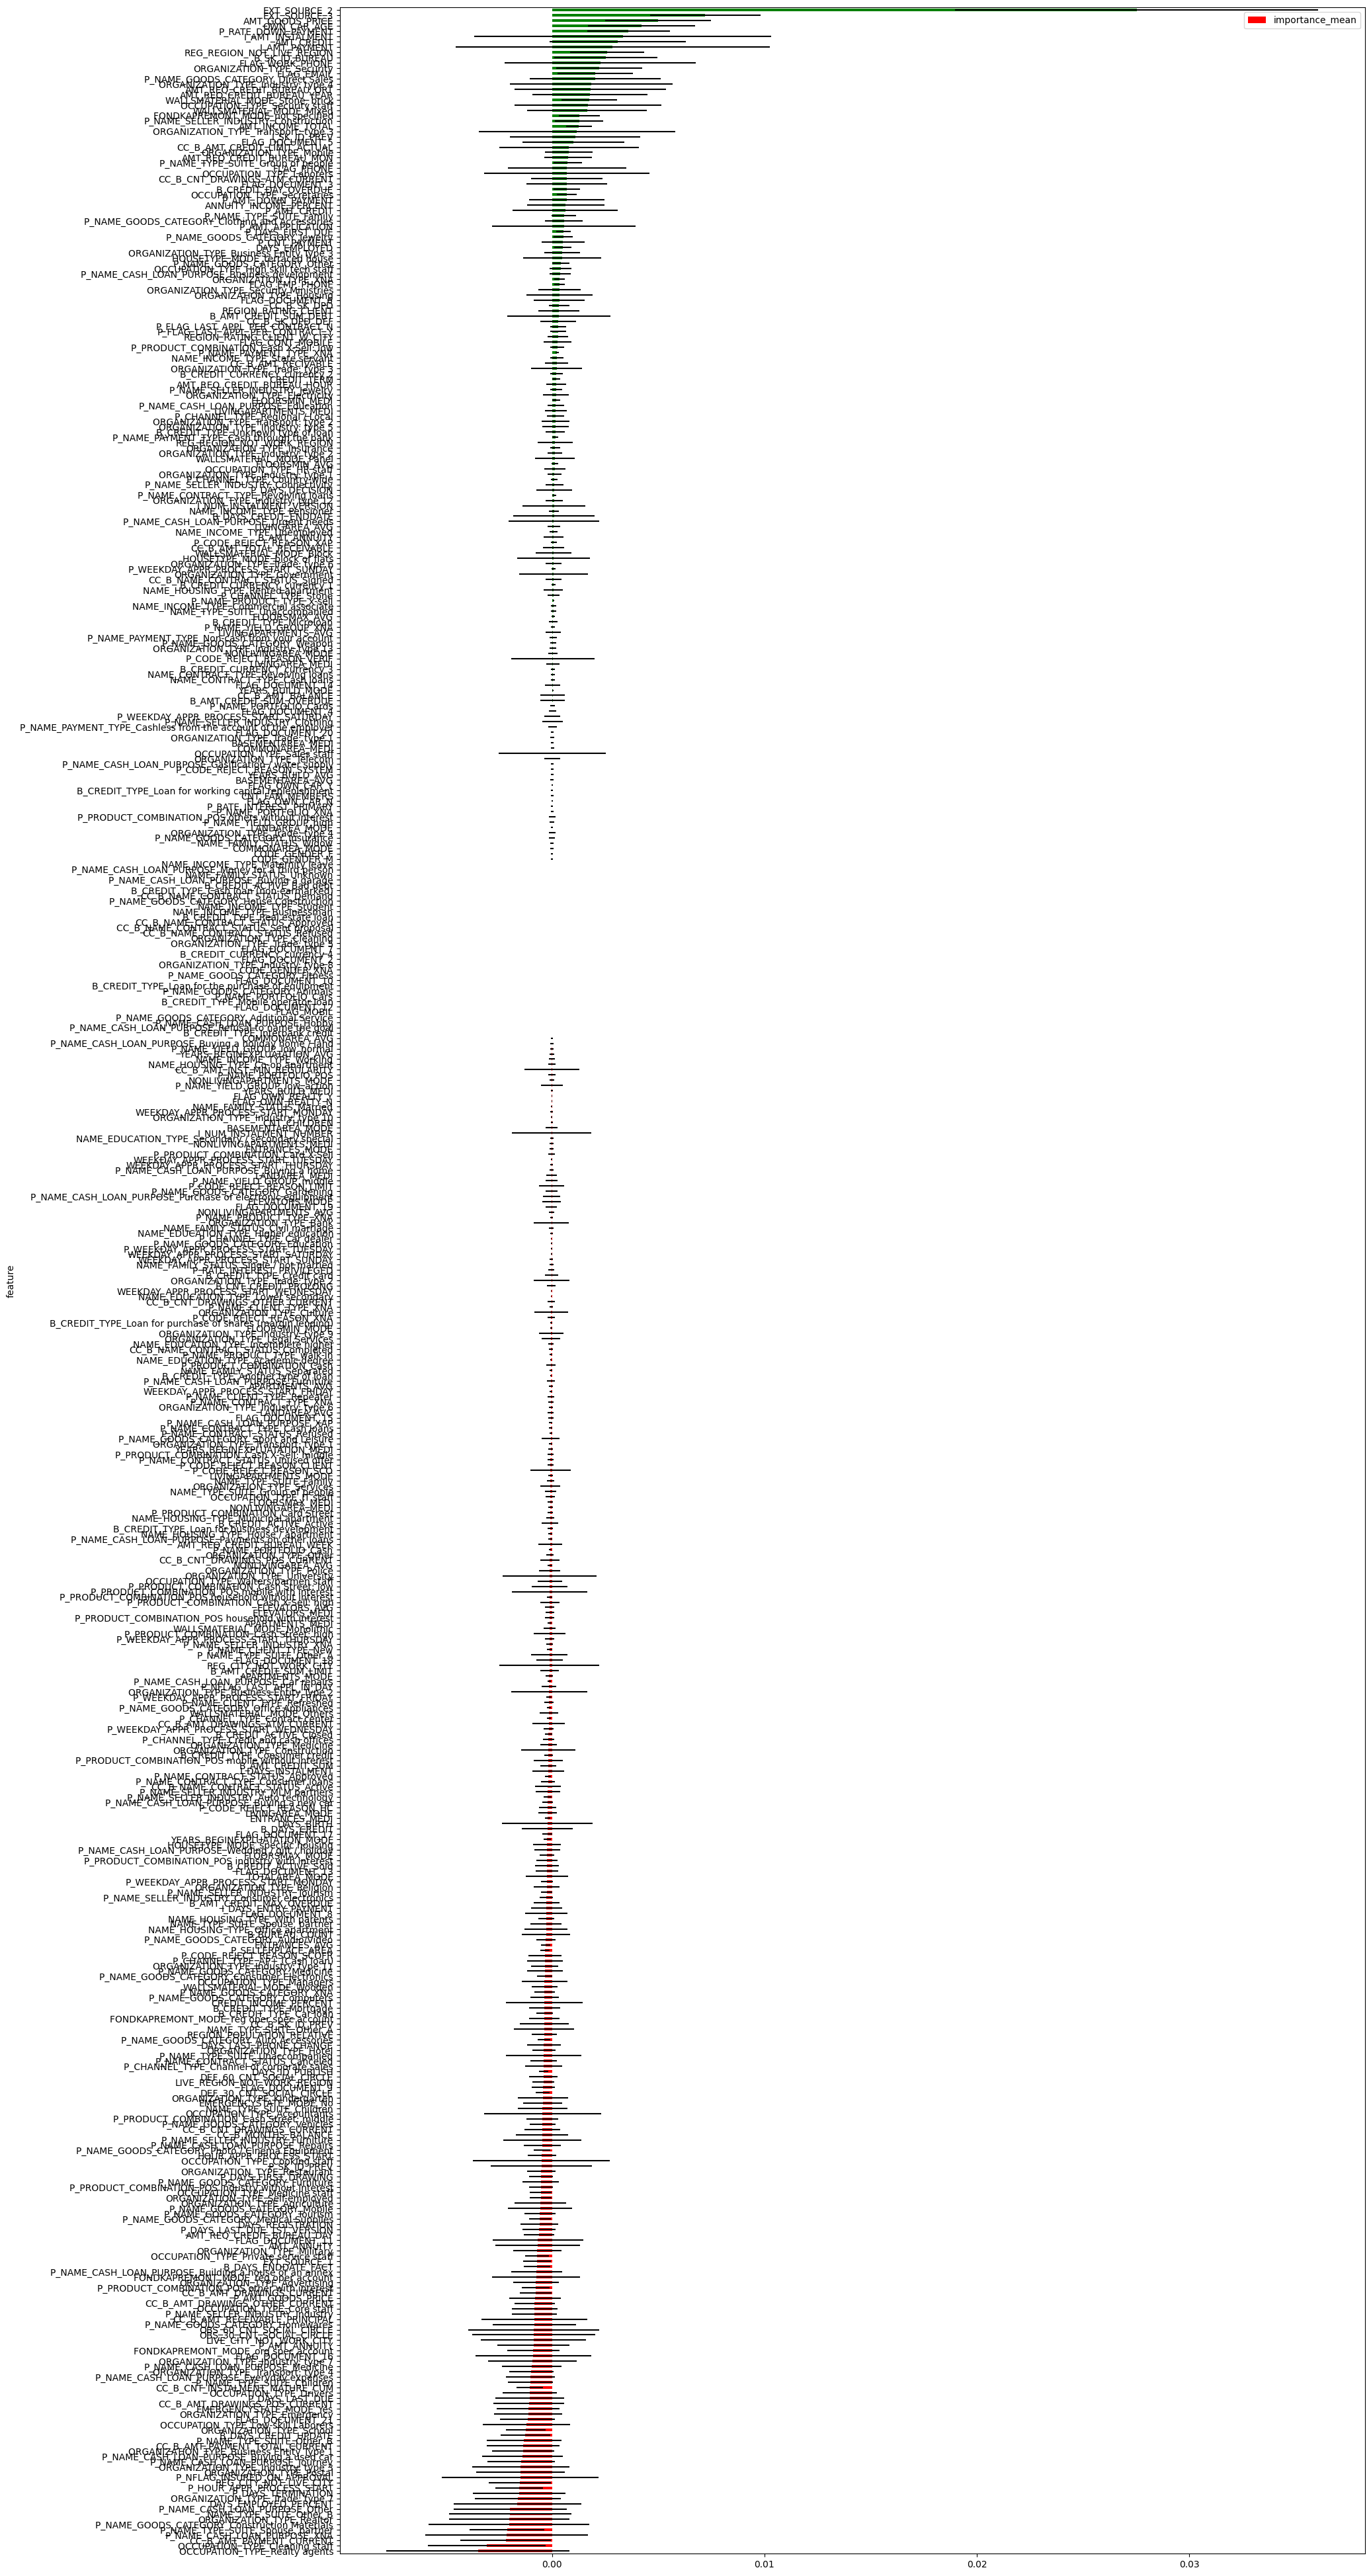

In [32]:
sample_df = train.sample(frac=0.01, random_state=0)

sample_df['TARGET'] = labels.loc[sample_df.index]
dataset = Dataset(df=sample_df, target="TARGET", features=train.columns)

lofo_imp = LOFOImportance(dataset, model=ridge_model, cv=stk_fold, scoring="roc_auc")

importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(20, 50))

In [33]:
selected_features = importance_df.sort_values(by='importance_mean', ascending=False).head(15)['feature'].tolist()
selected_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_GOODS_PRICE',
 'OWN_CAR_AGE',
 'P_RATE_DOWN_PAYMENT',
 'I_AMT_INSTALMENT',
 'AMT_CREDIT',
 'I_AMT_PAYMENT',
 'REG_REGION_NOT_LIVE_REGION',
 'B_SK_ID_BUREAU',
 'FLAG_WORK_PHONE',
 'ORGANIZATION_TYPE_Security',
 'FLAG_EMAIL',
 'P_NAME_GOODS_CATEGORY_Direct Sales',
 'ORGANIZATION_TYPE_Industry: type 4']

In [34]:
train_with_best_features = train[selected_features]
test_with_best_features = test[selected_features]

# 5. Hyperparameter Search 
#### Pros
* Returns best parameters for our model

#### Cons 
* Computationally Intensive


In [35]:
# I use small parameters to get output more quick
def catboost_objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000), 
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        eval_metric='AUC',
        verbose=True
    )
    auc = cross_validate_model(model, train_with_best_features, labels, stk_fold)
    return auc

In [36]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
pruner = optuna.pruners.MedianPruner() # terminate unpromising trials early, it prunes trials whose intermediate values are worse than the median
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler, pruner=pruner)
joblib.dump(study, "study.pkl")
study.optimize(catboost_objective, n_trials=5)

In [37]:
#study = joblib.load("study.pkl")

In [38]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  0.7304894914184699
  Params: 
    iterations: 284
    learning_rate: 0.05704727088203685
    depth: 4


In [39]:
cb_best_model = CatBoostClassifier(**trial.params, verbose=False)
cb_best_model.fit(train_with_best_features, labels, verbose=False) 
y_preds = cb_best_model.predict_proba(test_with_best_features)[:, 1]

In [40]:
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(cb_best_model, f)

In [41]:
subm['TARGET'] = y_preds
subm.to_csv('submission.csv', index=False)

# 6. Shap Values

In [42]:
explainer = shap.TreeExplainer(cb_best_model, num_iteration=cb_best_model.best_iteration_)
shap_values = explainer.shap_values(train_with_best_features)

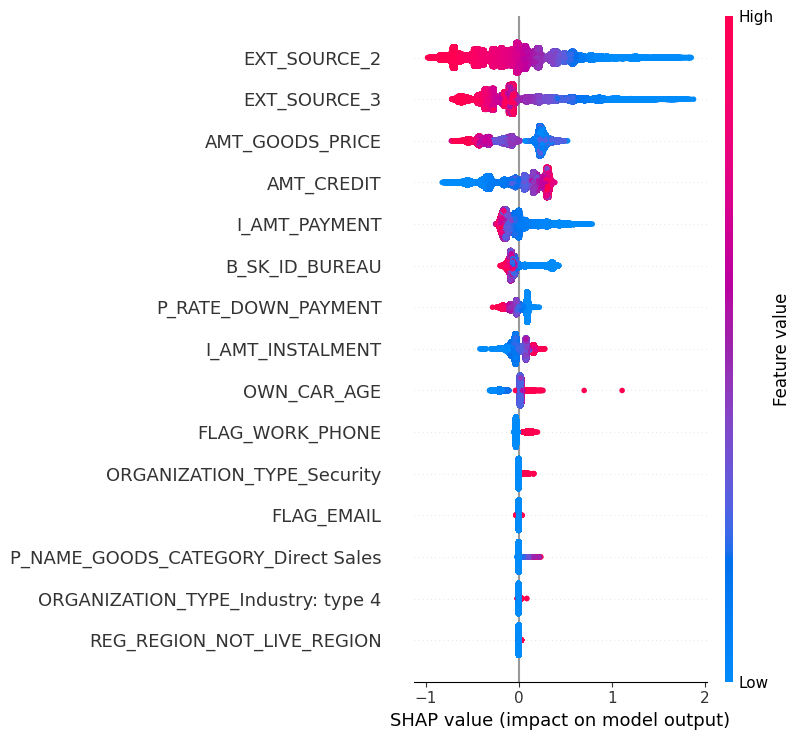

In [43]:
shap.summary_plot(shap_values, train_with_best_features, max_display=15)

In [44]:
shap.plots.force(explainer.expected_value, shap_values[0, ...])

In [45]:
#shap.plots.force(explainer.expected_value,shap_values)